# Fully Connected FeedForward Network

Each Node in layer __n__ projects to each and every node in layer __n+1__.

## MNIST Dataset

Database of images of hand-written digits from 0-9. 
Exploring the dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
data = np.loadtxt(open('../data/mnist_train_small.csv', 'rb'), delimiter=',')

In [3]:
data.shape

(20000, 785)

In [4]:
# separating data and labels
labels = data[:, 0]
data = data[:, 1:]

labels.shape, data.shape

((20000,), (20000, 784))

In [5]:
labels

array([6., 5., 7., ..., 2., 9., 5.])

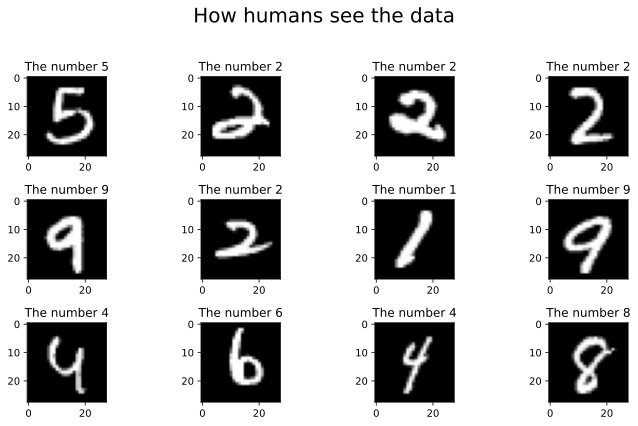

In [6]:
# show a few random digits
fig,axs = plt.subplots(3,4,figsize=(10,6))

for ax in axs.flatten():
    # pick a random image
    randimg2show = np.random.randint(0,high=data.shape[0])

    # create the image (must be reshaped!)
    img = np.reshape(data[randimg2show,:],(28,28))
    ax.imshow(img,cmap='gray')

    # title
    ax.set_title('The number %i'%labels[randimg2show])

plt.suptitle('How humans see the data',fontsize=20)
plt.tight_layout(rect=[0,0,1,.95])
plt.show()

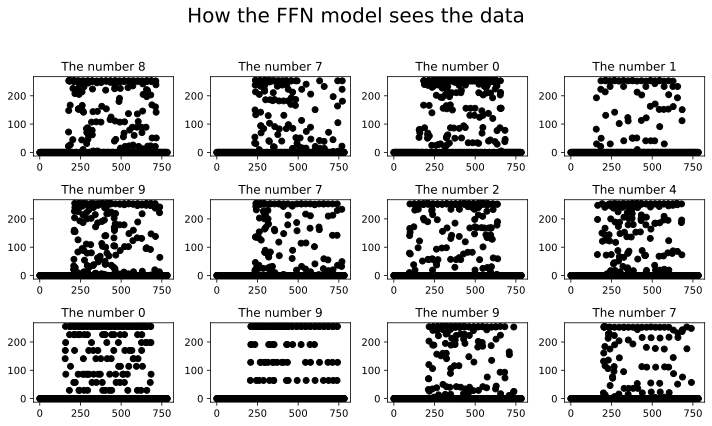

In [7]:
# show a few random digits
fig,axs = plt.subplots(3,4,figsize=(10,6))

for ax in axs.flatten():
  # pick a random image
  randimg2show = np.random.randint(0,high=data.shape[0])

  # create the image
  ax.plot(data[randimg2show,:],'ko')

  # title
  ax.set_title('The number %i'%labels[randimg2show])

plt.suptitle('How the FFN model sees the data',fontsize=20)
plt.tight_layout(rect=[0,0,1,.95])
plt.show()

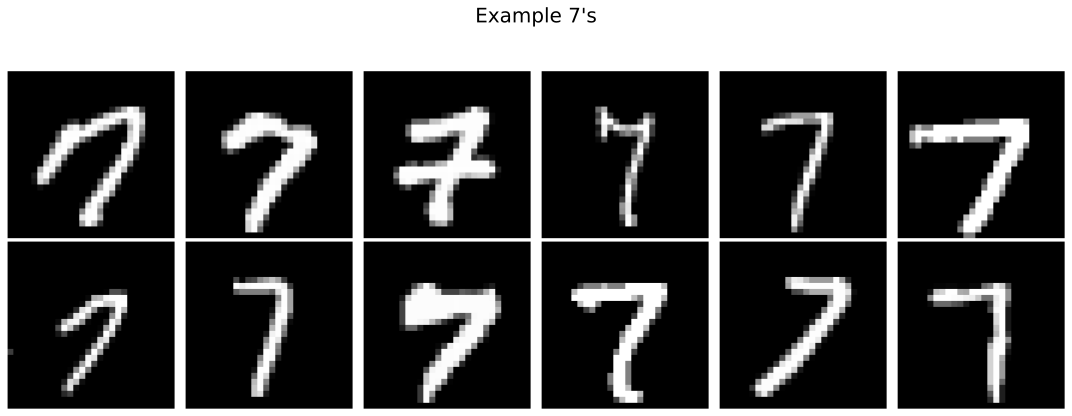

In [8]:
# examples of 7s

the7s = np.where(labels==7)[0]

# draw the first 12
fig,axs = plt.subplots(2,6,figsize=(15,6))

for i,ax in enumerate(axs.flatten()):
  img = np.reshape(data[the7s[i],:],(28,28))
  ax.imshow(img,cmap='gray')
  ax.axis('off')

plt.suptitle("Example 7's",fontsize=20)
plt.tight_layout(rect=[0,0,1,.95])
plt.show()

(2126, 784)


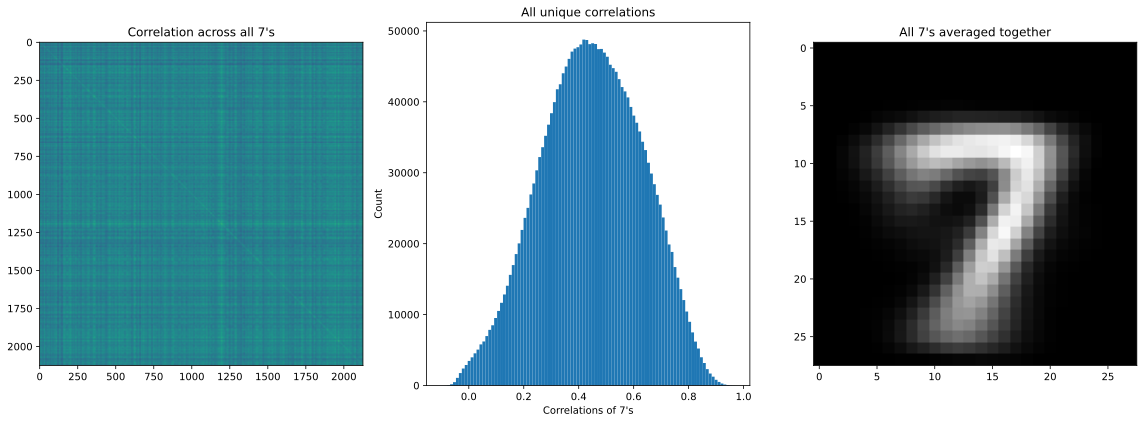

In [9]:
# how similar are all the 7's? 

# how many 7's are there?
print(data[the7s,:].shape)


# let's see how they relate to each other by computing spatial correlations
C = np.corrcoef(data[the7s,:])

# and visualize
fig,ax = plt.subplots(1,3,figsize=(16,6))
ax[0].imshow(C,vmin=0,vmax=1)
ax[0].set_title("Correlation across all 7's")

# extract the unique correlations and show as a scatterplot
uniqueCs = np.triu(C,k=1).flatten()
ax[1].hist(uniqueCs[uniqueCs!=0],bins=100)
ax[1].set_title('All unique correlations')
ax[1].set_xlabel("Correlations of 7's")
ax[1].set_ylabel('Count')

# show all 7's together
aveAll7s = np.reshape( np.mean(data[the7s,:],axis=0) ,(28,28))
ax[2].imshow(aveAll7s,cmap='gray')
ax[2].set_title("All 7's averaged together")

plt.tight_layout()
plt.show()

# Classifying MNIST digits

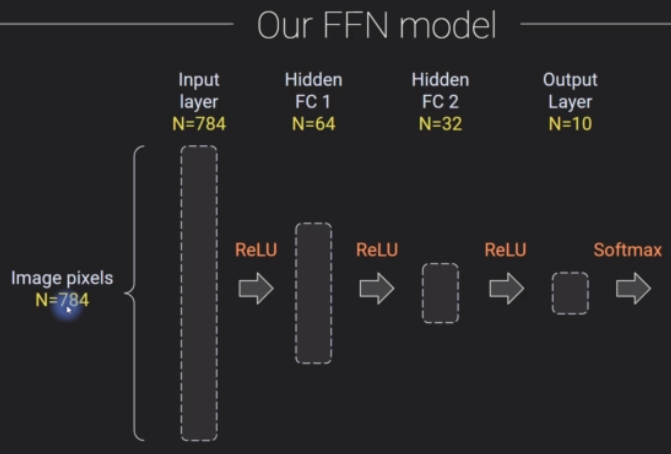

We use __log-softmax__ over linear softmax as the former stretches out the penalties for incorrect guesses which can improve categorical separability, and increase numerical stability.

Lin softmax performs better with "small" number of output categories (say 2-3), or when categories are easily differentiable. For many categories, log softmax tends to perform better (but no assumption).

In [10]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

from IPython import display
display.set_matplotlib_formats('svg')

In [11]:
data = np.loadtxt(open('../data/mnist_train_small.csv', 'rb'), delimiter=',')

labels = data[:, 0]
data = data[:, 1:]

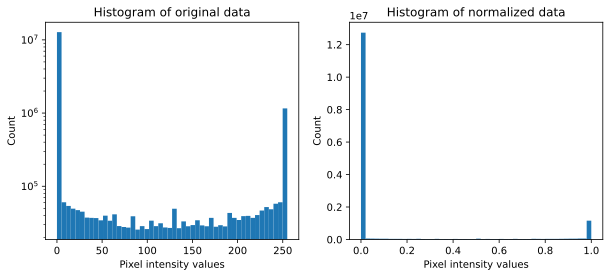

In [12]:
# normalizing data to a range of 0-1

dataNorm = data/np.max(data)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[0].set_yscale('log')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')

plt.show()

### Splitting the data into train and test, and loading

In [13]:
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()  # long = int64

X_train, X_test, y_train, y_test = train_test_split(dataT, labelsT, test_size=.1)

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

batchsize = 32
trainLoader = DataLoader(train_ds, batch_size=batchsize, shuffle=True, drop_last=True)
testLoader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0])

In [14]:
# check all variables in workspace
%whos

Variable           Type             Data/Info
---------------------------------------------
C                  ndarray          2126x2126: 4519876 elems, type `float64`, 36159008 bytes (34.483917236328125 Mb)
DataLoader         type             <class 'torch.utils.data.dataloader.DataLoader'>
F                  module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset      type             <class 'torch.utils.data.dataset.TensorDataset'>
X_test             Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
X_train            Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
aveAll7s           ndarray          28x28: 784 elems, type `float64`, 6272 bytes
ax                 ndarray          2: 2 elems, type `object`, 16 bytes
axs                ndarray          2x6: 12 elems, type `object`, 96 bytes
batchsize          int              32
data               ndarray          20000x784: 15680000 elems, type `float64`,

### DL Model

In [15]:
def createMNISTNet():
    
    class MNISTNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.ip = nn.Linear(784, 64)
            self.h1 = nn.Linear(64, 32)
            self.h2 = nn.Linear(32, 32)
            self.op = nn.Linear(32, 10)
        
        def forward(self, x):
            x = F.relu(self.ip(x))
            x = F.relu(self.h1(x))
            x = F.relu(self.h2(x))
            return torch.log_softmax(self.op(x), axis=1)
            # using log_softmax explicitly as NLLLoss is used 
            # instead of CELoss that implicitly computes softmax
            
    net = MNISTNet()
    
    lossfn = nn.NLLLoss()
    optim = torch.optim.SGD(net.parameters(), lr=.01)
    
    return net, lossfn, optim

In [16]:
# testing model with one batch

net, lossfn, optim = createMNISTNet()

x, y = next(iter(trainLoader))
yH = net(x)

print(yH.shape)

loss = lossfn(yH, y)

print('loss:', loss)

torch.Size([32, 10])
loss: tensor(2.3238, grad_fn=<NllLossBackward0>)


In [17]:
# function to train the model

def trainModel():
    
    nEp = 60
    net, lossfn, optim = createMNISTNet()
    losses, trainAcc, testAcc = torch.zeros(nEp), [], []
    
    # train loop
    for i in range(nEp):
        
        batchAcc, batchLoss = [], []
        
        # batch loop
        for x, y in trainLoader:
            yH = net(x)
            loss = lossfn(yH, y)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchLoss.append(loss.item())
            
            matches = torch.argmax(yH, axis=1) == y
            matchesNum = matches.float()
            accPt = 100*torch.mean(matchesNum)
            batchAcc.append(accPt)
        # end of batch loop
        
        trainAcc.append(np.mean(batchAcc))
        losses[i] = np.mean(batchLoss)
        
        X, y = next(iter(testLoader))
        yH = net(X)
        
        testAcc.append( 100*torch.mean((torch.argmax(yH,axis=1)==y).float()) )
    # end of training loop
    
    return net, trainAcc, testAcc, losses

In [18]:
net, trainAcc, testAcc, losses = trainModel()

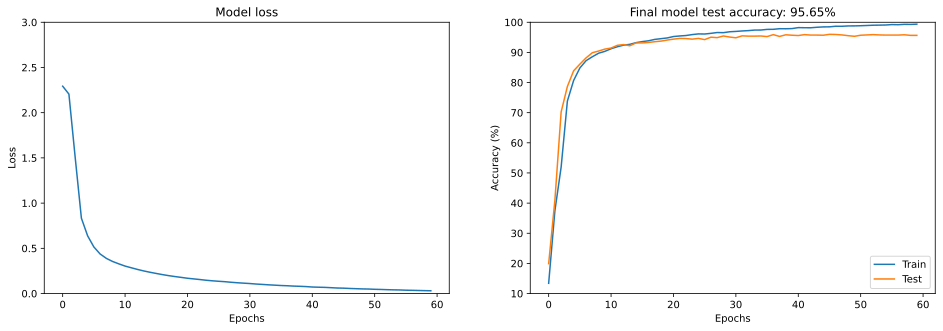

In [19]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [20]:
X,y = next(iter(testLoader))
predictions = net(X).detach()

predictions

tensor([[-2.9734e+01, -1.2933e-04, -2.1298e+01,  ..., -1.4024e+01,
         -9.1127e+00, -1.1364e+01],
        [-2.5475e+00, -1.5884e+01, -9.2059e+00,  ..., -1.3661e+01,
         -8.4893e+00, -1.2678e+01],
        [-1.9256e+01, -9.2508e+00, -1.9133e+01,  ..., -2.5580e+01,
         -1.3255e-04, -1.7303e+01],
        ...,
        [-1.8375e+01, -2.9392e+01, -2.3143e+01,  ..., -2.0519e+01,
         -1.6631e+01, -9.2187e+00],
        [-1.6319e+01, -2.7621e+01, -1.2713e+01,  ..., -8.9245e+00,
         -2.7621e-01, -1.4221e+00],
        [-1.3148e+01, -1.6626e+01, -1.2163e+01,  ..., -1.1014e-04,
         -1.0934e+01, -9.8753e+00]])

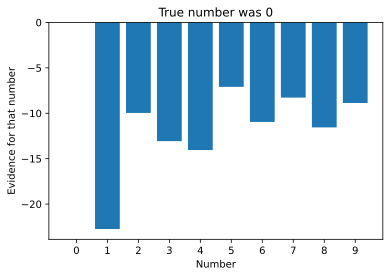

In [21]:
# Evidence for all numbers from one sample
sample2show = 120

plt.bar(range(10),predictions[sample2show]) # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' %y[sample2show].item())
plt.show()

[  63  157  168  182  185  187  238  252  269  325  373  384  409  415
  437  454  517  539  560  568  598  600  630  634  651  659  678  726
  728  804  814  836  868  879  899  938  981 1018 1023 1030 1040 1123
 1142 1152 1175 1186 1210 1219 1241 1258 1272 1287 1307 1310 1319 1329
 1339 1346 1365 1377 1418 1439 1473 1533 1534 1535 1564 1603 1607 1616
 1644 1670 1706 1707 1709 1710 1764 1782 1810 1833 1858 1872 1886 1888
 1904 1943 1979]


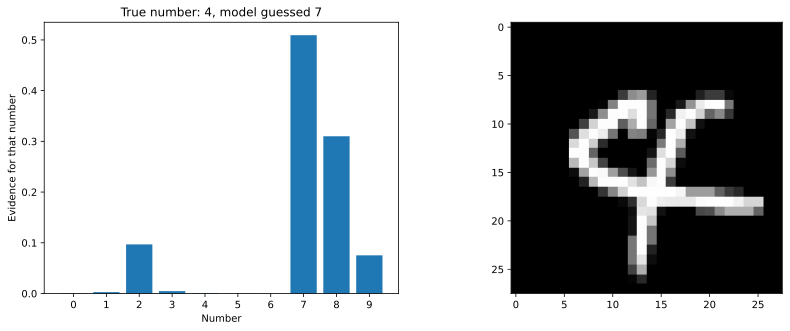

In [22]:
# find the errors
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 10

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s' 
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')

plt.show()

## Extracting weights in a model

In [16]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

from IPython import display
display.set_matplotlib_formats('svg')

data = np.loadtxt(open('../data/mnist_train_small.csv', 'rb'), delimiter=',')

labels = data[:, 0]
data = data[:, 1:]

# normalizing data to a range of 0-1

dataNorm = data/np.max(data)

### Splitting the data into train and test, and loading

dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()  # long = int64

X_train, X_test, y_train, y_test = train_test_split(dataT, labelsT, test_size=.1)

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

batchsize = 32
trainLoader = DataLoader(train_ds, batch_size=batchsize, shuffle=True, drop_last=True)
testLoader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0])

In [17]:
def createMNISTNet():
    
    class MNISTNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.ip = nn.Linear(784, 64)
            self.h1 = nn.Linear(64, 32)
            self.h2 = nn.Linear(32, 32)
            self.op = nn.Linear(32, 10)
        
        def forward(self, x):
            x = F.relu(self.ip(x))
            x = F.relu(self.h1(x))
            x = F.relu(self.h2(x))
            return torch.log_softmax(self.op(x), axis=1)
            # using log_softmax explicitly as NLLLoss is used 
            # instead of CELoss that implicitly computes softmax
            
    net = MNISTNet()
    
    lossfn = nn.NLLLoss()
    optim = torch.optim.SGD(net.parameters(), lr=.01)
    
    return net, lossfn, optim

# testing model with one batch

net, lossfn, optim = createMNISTNet()

x, y = next(iter(trainLoader))
yH = net(x)

print(yH.shape)

loss = lossfn(yH, y)

print('loss:', loss)

In [18]:
net = createMNISTNet()[0]

# summary of model
print(net)

In [19]:
print('Summary of ip layer:\n', vars(net.ip))

In [20]:
# accessing the weights
print(net.ip.weight.shape)
print(net.ip.weight)

In [21]:
# # # finally, extract the weights and make a histogram
# w = net.ip.weight.detach().flatten()
# plt.hist(w,40)
# plt.xlabel('Weight value')
# plt.ylabel('Count')
# plt.title('Distribution of initialized input-layer weights')
# plt.show()

In [22]:
# a function that returns a histogram of all weights (across all layers)

def weightsHistogram(net):

  # initialize weight vector
  W = np.array([])
  
  # concatenate each set of weights
  for layer in net.parameters():
    W = np.concatenate((W,layer.detach().flatten().numpy() ))

  # compute their histogram (note: range is hard-coded)
  histy,histx = np.histogram(W,bins=np.linspace(-.8,.8,101),density=True)
  histx = (histx[1:]+histx[:-1])/2
  return histx,histy




# test it!
histx,histy = weightsHistogram(net)
plt.plot(histx,histy);

In [23]:
# function to train the model

def trainModel():
    
    nEp = 60
    net, lossfn, optim = createMNISTNet()
    losses, trainAcc, testAcc = torch.zeros(nEp), [], []
    
    histx = np.zeros((nEp, 100))
    histy = np.zeros((nEp, 100))
    
    # train loop
    for i in range(nEp):
        
        histx, histy[i,:] = weightsHistogram(net)
        
        batchAcc, batchLoss = [], []
        
        # batch loop
        for x, y in trainLoader:
            yH = net(x)
            loss = lossfn(yH, y)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchLoss.append(loss.item())
            
            matches = torch.argmax(yH, axis=1) == y
            matchesNum = matches.float()
            accPt = 100*torch.mean(matchesNum)
            batchAcc.append(accPt)
        # end of batch loop
        
        trainAcc.append(np.mean(batchAcc))
        losses[i] = np.mean(batchLoss)
        
        X, y = next(iter(testLoader))
        yH = net(X)
        
        testAcc.append( 100*torch.mean((torch.argmax(yH,axis=1)==y).float()) )
    # end of training loop
    
    return net, trainAcc, testAcc, losses, histx, histy

In [24]:
net, trainAcc, testAcc, losses, histx, histy = trainModel()

In [25]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [26]:
# show the histogram of the weights

fig,ax = plt.subplots(1,2,figsize=(15,5))

for i in range(histy.shape[0]):
  ax[0].plot(histx,histy[i,:],color=[1-i/100,.3,i/100])

ax[0].set_title('Histograms of weights')
ax[0].set_xlabel('Weight value')
ax[0].set_ylabel('Density')


ax[1].imshow(histy,vmin=0,vmax=3,
             extent=[histx[0],histx[-1],0,99],aspect='auto',origin='lower',cmap='hot')
ax[1].set_xlabel('Weight value')
ax[1].set_ylabel('Training epoch')
ax[1].set_title('Image of weight histograms')

plt.show()

## Scrambled MNIST

We will see that the feed forwards do not leverage any spatial info or properties of image/data. Hence, the performance of FFN doesn't get affected by randomizing or adding noise to the data (while training or testing)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

from IPython import display
display.set_matplotlib_formats('svg')

data = np.loadtxt(open('../data/mnist_train_small.csv', 'rb'), delimiter=',')

labels = data[:, 0]
data = data[:, 1:]

# normalizing data to a range of 0-1

dataNorm = data/np.max(data)

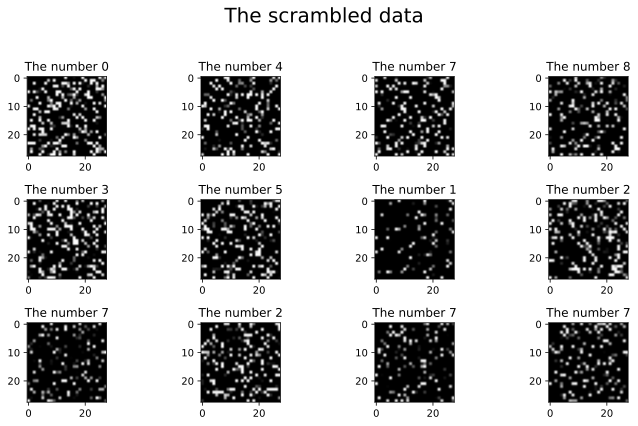

In [2]:
# scambling the data using permutation - shuffling the data

noise = np.random.permutation(data.shape[1]) # number of columns - 784
scrambled = dataNorm[:, noise]

# show a few random digits
fig,axs = plt.subplots(3,4,figsize=(10,6))

for ax in axs.flatten():
    # pick a random image
    randimg2show = np.random.randint(0,high=data.shape[0])

    # create the image (must be reshaped!)
    img = np.reshape(scrambled[randimg2show,:],(28,28))
    ax.imshow(img,cmap='gray')

    # title
    ax.set_title('The number %i'%labels[randimg2show])

plt.suptitle('The scrambled data',fontsize=20)
plt.tight_layout(rect=[0,0,1,.95])
plt.show()

torch.Size([32, 10])
loss: tensor(2.3226, grad_fn=<NllLossBackward0>)


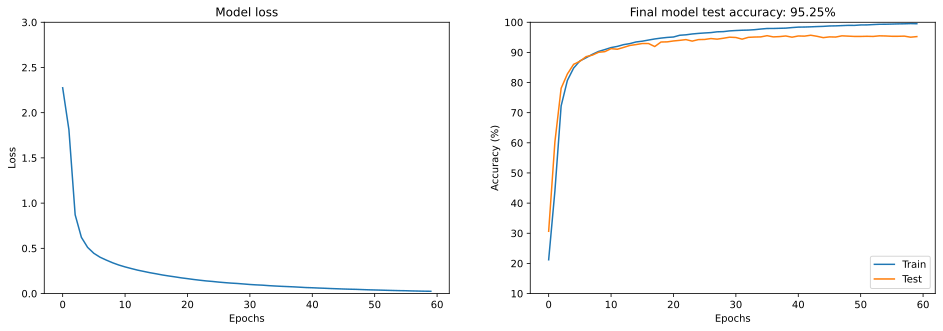

In [5]:
### Splitting the data into train and test, and loading

dataT = torch.tensor(scrambled).float()
labelsT = torch.tensor(labels).long()  # long = int64

X_train, X_test, y_train, y_test = train_test_split(dataT, labelsT, test_size=.1)

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

batchsize = 32
trainLoader = DataLoader(train_ds, batch_size=batchsize, shuffle=True, drop_last=True)
testLoader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0])

### DL Model

def createMNISTNet():
    
    class MNISTNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.ip = nn.Linear(784, 64)
            self.h1 = nn.Linear(64, 32)
            self.h2 = nn.Linear(32, 32)
            self.op = nn.Linear(32, 10)
        
        def forward(self, x):
            x = F.relu(self.ip(x))
            x = F.relu(self.h1(x))
            x = F.relu(self.h2(x))
            return torch.log_softmax(self.op(x), axis=1)
            # using log_softmax explicitly as NLLLoss is used 
            # instead of CELoss that implicitly computes softmax
            
    net = MNISTNet()
    
    lossfn = nn.NLLLoss()
    optim = torch.optim.SGD(net.parameters(), lr=.01)
    
    return net, lossfn, optim

# testing model with one batch

net, lossfn, optim = createMNISTNet()

x, y = next(iter(trainLoader))
yH = net(x)

print(yH.shape)

loss = lossfn(yH, y)

print('loss:', loss)

# function to train the model

def trainModel():
    
    nEp = 60
    net, lossfn, optim = createMNISTNet()
    losses, trainAcc, testAcc = torch.zeros(nEp), [], []
    
    # train loop
    for i in range(nEp):
        
        batchAcc, batchLoss = [], []
        
        # batch loop
        for x, y in trainLoader:
            yH = net(x)
            loss = lossfn(yH, y)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchLoss.append(loss.item())
            
            matches = torch.argmax(yH, axis=1) == y
            matchesNum = matches.float()
            accPt = 100*torch.mean(matchesNum)
            batchAcc.append(accPt)
        # end of batch loop
        
        trainAcc.append(np.mean(batchAcc))
        losses[i] = np.mean(batchLoss)
        
        X, y = next(iter(testLoader))
        yH = net(X)
        
        testAcc.append( 100*torch.mean((torch.argmax(yH,axis=1)==y).float()) )
    # end of training loop
    
    return net, trainAcc, testAcc, losses

net, trainAcc, testAcc, losses = trainModel()

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Shiting MNIST

Shifting all MNIST images to right/left (called as "rolling" in pytorch). It is trivial to see that this will not affect the performance of FFNs in categorization.

Here, we will leave train images as they are, and shift test images by a few pixels.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

from IPython import display
display.set_matplotlib_formats('svg')

data = np.loadtxt(open('../data/mnist_train_small.csv', 'rb'), delimiter=',')

labels = data[:, 0]
data = data[:, 1:]

# normalizing data to a range of 0-1

dataNorm = data/np.max(data)

### Splitting the data into train and test, and loading

dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()  # long = int64

X_train, X_test, y_train, y_test = train_test_split(dataT, labelsT, test_size=.1)

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

batchsize = 32
trainLoader = DataLoader(train_ds, batch_size=batchsize, shuffle=True, drop_last=True)
testLoader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0])

## shifting images by few pizels

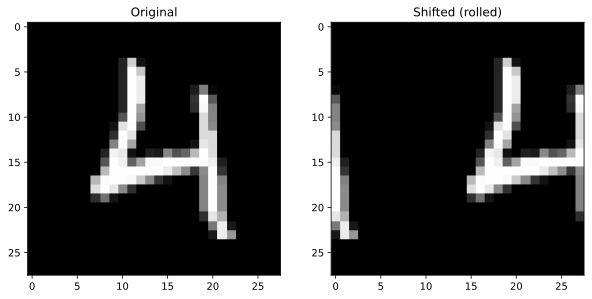

In [16]:
tmp = testLoader.dataset.tensors[0][0,:]
tmp = tmp.reshape(28, 28)

# shifting the image
tmpS = torch.roll(tmp, 8, dims=1) # shifting or "rolling" by 8 pixels

# now show them both
fig,ax = plt.subplots(1,2,figsize=(10,6))
ax[0].imshow(tmp, cmap='gray')
ax[0].set_title('Original')

ax[1].imshow(tmpS, cmap='gray')
ax[1].set_title('Shifted (rolled)')

plt.show()

In [18]:
# repeating for all test images

for i in range(testLoader.dataset.tensors[0].shape[0]):
    img = testLoader.dataset.tensors[0][i, :]
    
    # reshape and roll by 10 pixels
    randroll = np.random.randint(-10, 11)
    img = torch.roll(img.reshape(28,28), randroll, dims=1)
    
    testLoader.dataset.tensors[0][i,:] = img.reshape(1,-1)

torch.Size([32, 10])
loss: tensor(2.3091, grad_fn=<NllLossBackward0>)


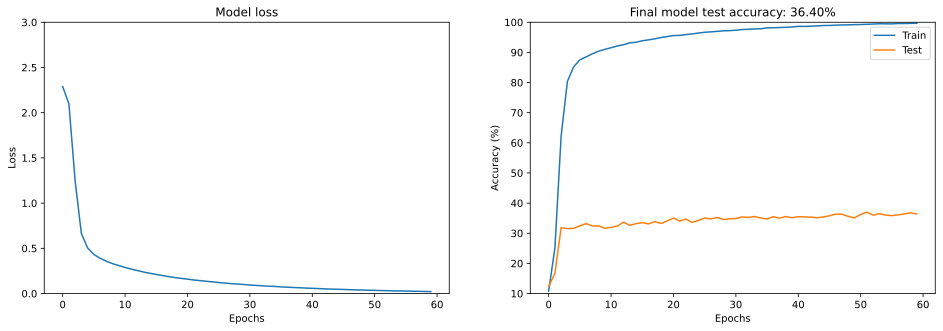

In [19]:
### DL Model

def createMNISTNet():
    
    class MNISTNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.ip = nn.Linear(784, 64)
            self.h1 = nn.Linear(64, 32)
            self.h2 = nn.Linear(32, 32)
            self.op = nn.Linear(32, 10)
        
        def forward(self, x):
            x = F.relu(self.ip(x))
            x = F.relu(self.h1(x))
            x = F.relu(self.h2(x))
            return torch.log_softmax(self.op(x), axis=1)
            # using log_softmax explicitly as NLLLoss is used 
            # instead of CELoss that implicitly computes softmax
            
    net = MNISTNet()
    
    lossfn = nn.NLLLoss()
    optim = torch.optim.SGD(net.parameters(), lr=.01)
    
    return net, lossfn, optim

# testing model with one batch

net, lossfn, optim = createMNISTNet()

x, y = next(iter(trainLoader))
yH = net(x)

print(yH.shape)

loss = lossfn(yH, y)

print('loss:', loss)

# function to train the model

def trainModel():
    
    nEp = 60
    net, lossfn, optim = createMNISTNet()
    losses, trainAcc, testAcc = torch.zeros(nEp), [], []
    
    # train loop
    for i in range(nEp):
        
        batchAcc, batchLoss = [], []
        
        # batch loop
        for x, y in trainLoader:
            yH = net(x)
            loss = lossfn(yH, y)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchLoss.append(loss.item())
            
            matches = torch.argmax(yH, axis=1) == y
            matchesNum = matches.float()
            accPt = 100*torch.mean(matchesNum)
            batchAcc.append(accPt)
        # end of batch loop
        
        trainAcc.append(np.mean(batchAcc))
        losses[i] = np.mean(batchLoss)
        
        X, y = next(iter(testLoader))
        yH = net(X)
        
        testAcc.append( 100*torch.mean((torch.argmax(yH,axis=1)==y).float()) )
    # end of training loop
    
    return net, trainAcc, testAcc, losses

net, trainAcc, testAcc, losses = trainModel()

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

Above result shows that spatial changes in test data (just like how it is there in real world), had adverse effects on the performance of FFNs. This is why there are CNNs that capture spatial properties of data and perform better on changes in test data than FFNs

# Universal Approximation Theorem (UAT)

It states that - a suffuciently wide or deep network can approximate any possible function.

$$\sup_{x,\theta}||f(x) - g_\theta(x)|| < \epsilon$$

$x$ refers to the input data, $\theta$ refers to the model parameters (weights, biases, hyperparameters), $f$ refers to the true function in real world, $g_\theta$ refers to the neural network model with $\theta$ parameters, $\epsilon$ refers to arbitrary tiny number. 

Claims of UAT is theoretical, and is not guaranteed in real world. It assumes that the network is shallow but arbitrarily wide, or arbitrarily deep but narrow.